# 1. Setup i obtenció de les dades

## 1.1 Instalar dependencies i setup

In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

## 1.2 Obtencio d'imatges mitjançant OpenCV

In [18]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data', 'images')
n_images = 30

In [4]:
cap = cv2.VideoCapture(0)
for imgnum in range(n_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

## 1.3 anotar les imatges amb LABELME

In [8]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\adria\.labelmerc


# 2. Revisar el dataset i fer la funció per carregar les images

## 2.1 Imports

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limitar GPU Memory Growth

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

## 2.3 Carregar imatges al pipeline de TF

In [9]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [13]:
images.as_numpy_iterator().next()

b'data\\images\\75dbd31d-7896-11ee-b9e9-ccf9e4912647.jpg'

In [1]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
images = images.map(load_image)

In [10]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

## 2.4 Vosualitzar imatges RAW amb Matplotlib

In [17]:
image_generator = images.batch(4).as_numpy_iterator()

In [20]:
plot_images = image_generator.next()

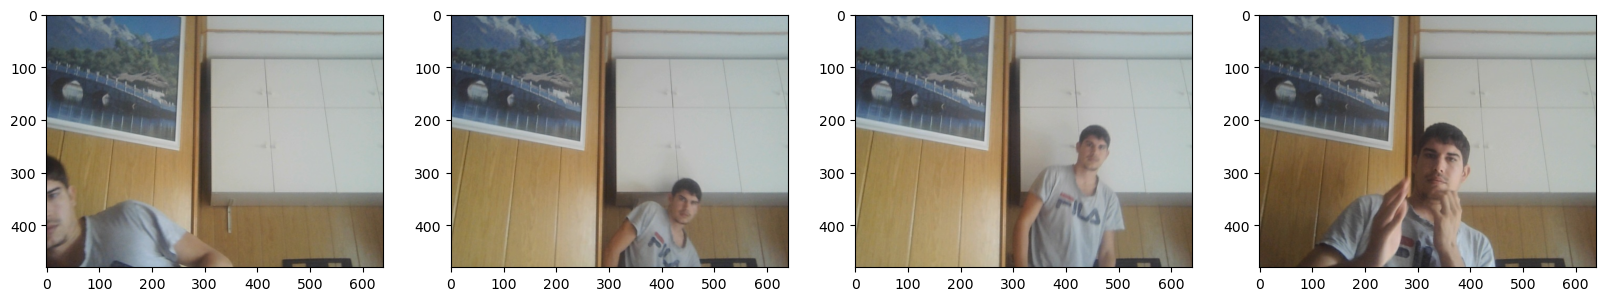

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Particio del dataset

## 3.1 Partir manualment el dataset en TRAIN, TEST i VAL

In [22]:
# 70% del conjunt aniran pel train = 63 fotos
# l'altre 30% es reparteix entre test i val = 14 i 13 fotos cadascun

## 3.2 Moure els labels corresponents per cada imatge 

In [23]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Aplicar augments a les imatges i labels mitjançant Albumentations

# 4.1 Setup Albumentations Transform Pipeline

In [24]:
import albumentations as alb

In [25]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## 4.2 Carrega una imatge del conjunt Test i el seu label amb OpenCV i JSON

In [26]:
img = cv2.imread(os.path.join('data','train', 'images','2a13ddeb-7896-11ee-ad81-ccf9e4912647.jpg'))

In [27]:
with open(os.path.join('data', 'train', 'labels', '2a13ddeb-7896-11ee-ad81-ccf9e4912647.json'), 'r') as f:
    label = json.load(f)

## 4.3 Extreure coordenades i reescalar per coincidir amb la resolucio de la imatge

In [29]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [31]:
coords = list(np.divide(coords, [640,480,640,480]))

## 4.4 Aplicar augments i visualitzar els resultats

In [32]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

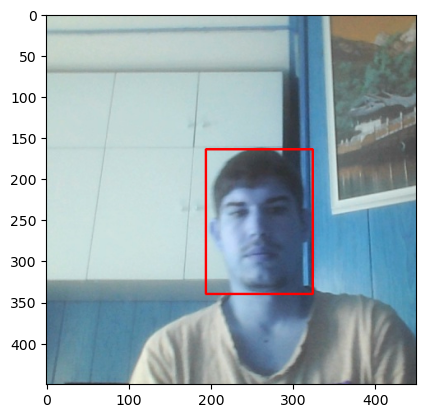

In [33]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Crear i executar l'Augmentation Pipeline

## 5.1 Executa l'Augmentation Pipeline

In [34]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

## 5.2 Carrega les Augmented imatges al dataset de tensorflow

In [4]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [5]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [6]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

# 6. Prepara els labels

## 6.1 Crea la funcio per carregar labels

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

## 6.2 Carrega els labels al dataset de Tensorflow

In [8]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [9]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# 7. Combina els labels amb les imatges

## 7.1 Comproba la partició

In [11]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

## 7.2 Crea el dataset final (imatges/labels)

In [12]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [13]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [14]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

## 7.3 Visualitza les imatges i les anotacions

In [15]:
data_samples = train.as_numpy_iterator()

In [16]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


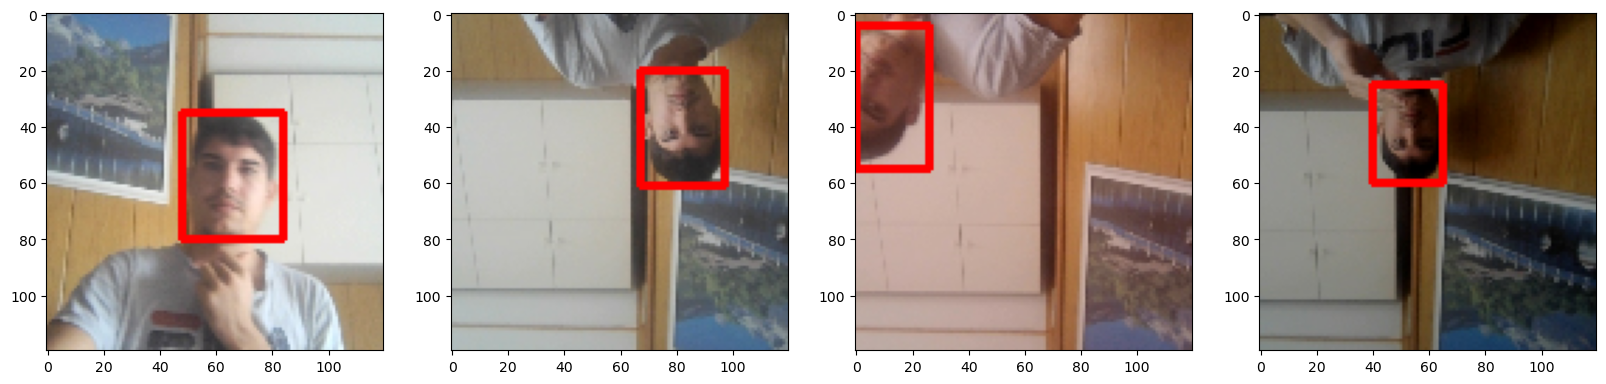

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Crea el Deep Learning mitjançant la funció API

## 8.1 Imports

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Descarrega VGG16

In [21]:
vgg = VGG16(include_top=False)

## 8.3 Crea la xarxa

In [22]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## 8.4 Test Xarxa Neuronal

In [23]:
facetracker = build_model()

In [24]:
X, y = train.as_numpy_iterator().next()

In [25]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


# 9. Defineix les perdues i els optimitzadors

## 9.1 Defineix l'optimitzador i LR

In [26]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [27]:
lr_decay

0.0007047216349541929

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=lr_decay)

## 9.2 Crea la Localization Loss i la Classification Loss

In [29]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [30]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test de les metriques Loss

In [31]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.3191996>

In [32]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6580652>

In [33]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.3191996>

# 10.Train de la Xarxa Neuronal

## 10.1 Creació d'una clase per a un Model Personalitzat

In [34]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [35]:
model = FaceTracker(facetracker)

In [36]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [37]:
logdir='logs'

In [38]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 1418s 3s/step - total_loss: 0.4029 - class_loss: 0.1133 - regress_loss: 0.3462 - val_total_loss: 0.1002 - val_class_loss: 0.0115 - val_regress_loss: 0.0945
Epoch 2/10
473/473 [==============================] - 984s 2s/step - total_loss: 0.0618 - class_loss: 0.0147 - regress_loss: 0.0545 - val_total_loss: 0.0068 - val_class_loss: 0.0032 - val_regress_loss: 0.0052
Epoch 3/10
473/473 [==============================] - 3563s 8s/step - total_loss: 0.0584 - class_loss: 0.0139 - regress_loss: 0.0514 - val_total_loss: 0.0204 - val_class_loss: 0.0062 - val_regress_loss: 0.0173
Epoch 4/10
473/473 [==============================] - 3756s 8s/step - total_loss: 0.1158 - class_loss: 0.0394 - regress_loss: 0.0961 - val_total_loss: 0.0509 - val_class_loss: 0.0409 - val_regress_loss: 0.0305
Epoch 5/10
473/473 [==============================] - 3088s 7s/step - total_loss: 0.0397 - class_loss: 0.0098 - regress_loss: 0.0348 - val_total_loss: 0.0677 - v

## 10.3 Plot

In [40]:
hist.history

{'total_loss': [0.20056909322738647,
  0.020580511540174484,
  0.009211037307977676,
  0.07101649791002274,
  0.0038209755439311266,
  0.04910586029291153,
  0.008935621939599514,
  0.0016969002317637205,
  0.0036127332132309675,
  0.01943056471645832],
 'class_loss': [0.08703124523162842,
  0.009819618426263332,
  0.00012413451622705907,
  0.01142699085175991,
  0.000346709304722026,
  0.00020225391199346632,
  0.00011647950304904953,
  0.00012099643936380744,
  0.000555556733161211,
  4.5375985791906714e-05],
 'regress_loss': [0.15705347061157227,
  0.01567070186138153,
  0.009148970246315002,
  0.0653030052781105,
  0.003647620789706707,
  0.04900473356246948,
  0.00887738261371851,
  0.0016364019829779863,
  0.003334954846650362,
  0.01940787583589554],
 'val_total_loss': [0.10017827153205872,
  0.006770201958715916,
  0.020351558923721313,
  0.05093890428543091,
  0.06768570095300674,
  0.12346295267343521,
  0.011483856476843357,
  0.014141904190182686,
  0.007477474864572287,
  

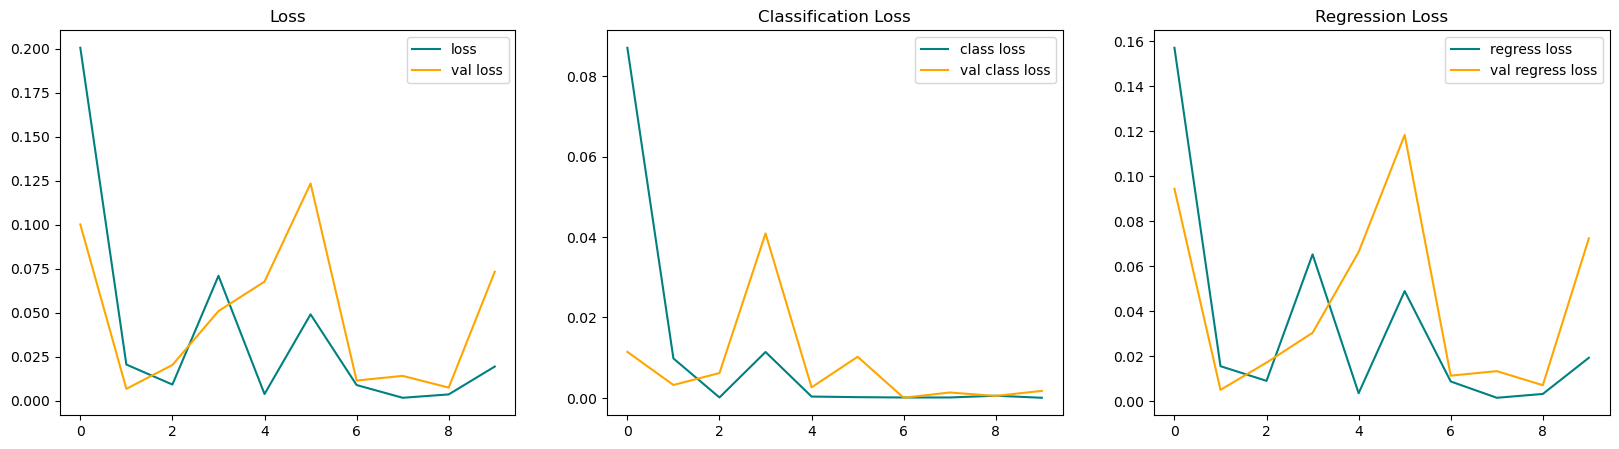

In [41]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Prediccions

## 11.1 Prediccions al test

In [42]:
test_data = test.as_numpy_iterator()

In [43]:
test_sample = test_data.next()

In [44]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 289ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


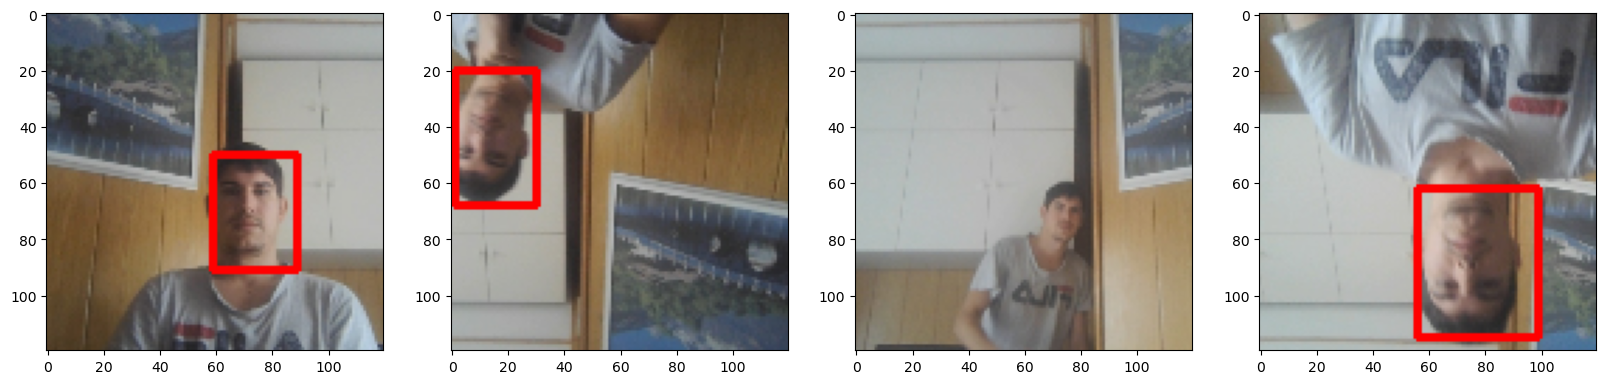

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Guardem el model

In [46]:
from tensorflow.keras.models import load_model

In [47]:
facetracker.save('facetracker.h5')

C:\Users\adria\anaconda3.1\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
facetracker = load_model('facetracker.h5')

## 11.3 Detecció en temps real

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 63ms/step
